## Loading necessary libraries

In [1]:
import pandas as pd, numpy as np, pickle
from interactiontransformer.InteractionTransformer import InteractionTransformer, run_shap
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from imblearn.ensemble import BalancedRandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib as mpl
import scipy
from sklearn.metrics import roc_auc_score
import warnings
warnings.filterwarnings("ignore")
mpl.rcParams['figure.dpi'] = 300
sns.set(style='white',font_scale=0.5)

/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


## Loading the data

In [2]:
df=pd.read_csv('../test_data/epistasis.test.csv')
X,y=df.iloc[:,:-1],df.iloc[:,-1]

## Train Test Split

In [3]:
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=42,stratify=y,shuffle=True)

## Find the top interactions in the training set

In [4]:
transformer=InteractionTransformer(max_train_test_samples=1000,mode_interaction_extract=int(np.sqrt(X_train.shape[1]))) # mode_interaction_extract='sqrt'
transformer.fit(X_train,y_train)

## Transform design matrices for training and test sets

In [5]:
X_train2=transformer.transform(X_train)
X_test2=transformer.transform(X_test)

## Extract top ranked interactions via SHAP

In [6]:
transformer.all_interaction_shap_scores.sort_values('shap_interaction_score',ascending=False).iloc[:10]

,feature_1,feature_2,shap_interaction_score
1532,P1_1,P2_1,0.027191
1531,P1_1,P2_0,0.022998
1528,P1_0,P2_1,0.018854
1527,P1_0,P2_0,0.017997
1238,N11_1,P2_1,0.004296
712,N5_0,N17_1,0.003068
1229,N11_1,N16_1,0.003035
1206,N11_0,N17_0,0.003008
420,N3_0,N6_0,0.002960
725,N5_1,N7_1,0.002794


## Fit Models and then get AUROC

In [7]:
lr=LogisticRegression(random_state=42,class_weight='balanced').fit(X_train,y_train)
lr2=LogisticRegression(random_state=42,class_weight='balanced').fit(X_train2,y_train)
rf=BalancedRandomForestClassifier(random_state=42).fit(X_train,y_train)

print(roc_auc_score(y_test,lr.predict_proba(X_test)[:,-1]))
print(roc_auc_score(y_test,lr2.predict_proba(X_test2)[:,-1]))
print(roc_auc_score(y_test,rf.predict_proba(X_test)[:,-1]))

0.47324999999999995
0.8470750000000001
0.7993


## Collect SHAP Feature Importances

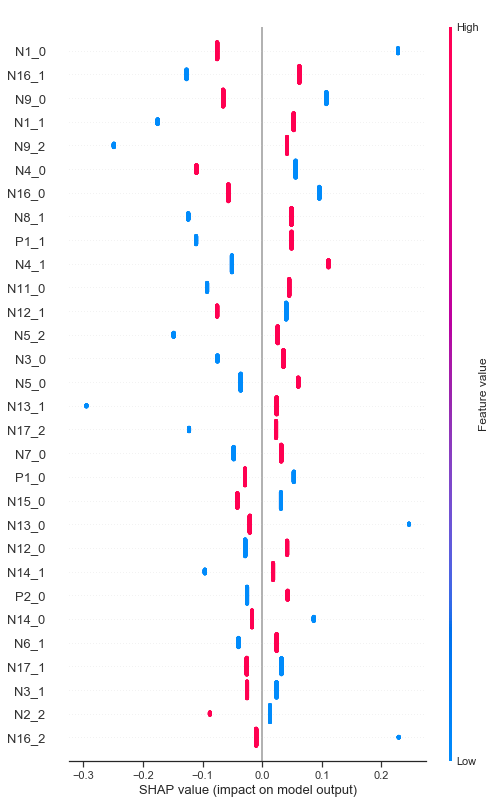

<Figure size 432x288 with 0 Axes>

In [12]:
shap_lr=run_shap(X_train, X_test, lr, model_type='linear', explainer_options={}, get_shap_values_options={}, overall=False, savefile='../test_data/epistasis.lr.shap.png')

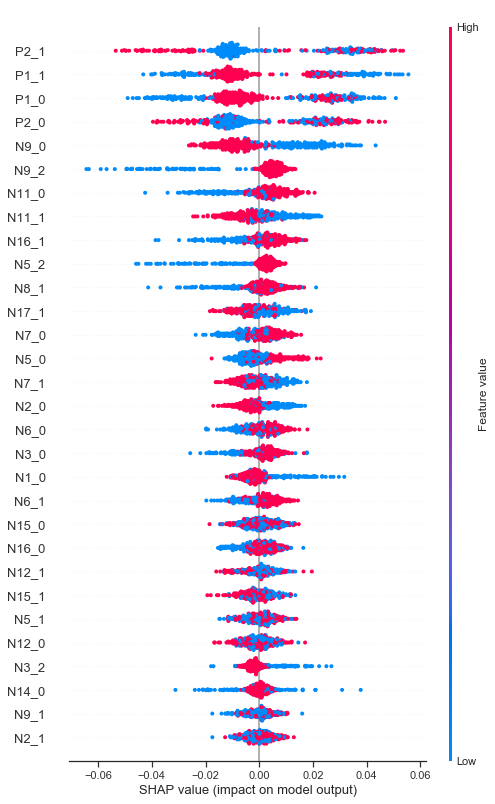

<Figure size 432x288 with 0 Axes>

In [13]:
shap_rf=run_shap(X_train, X_test, rf, model_type='tree', explainer_options={}, get_shap_values_options={}, overall=False, savefile='../test_data/epistasis.rf.shap.png')

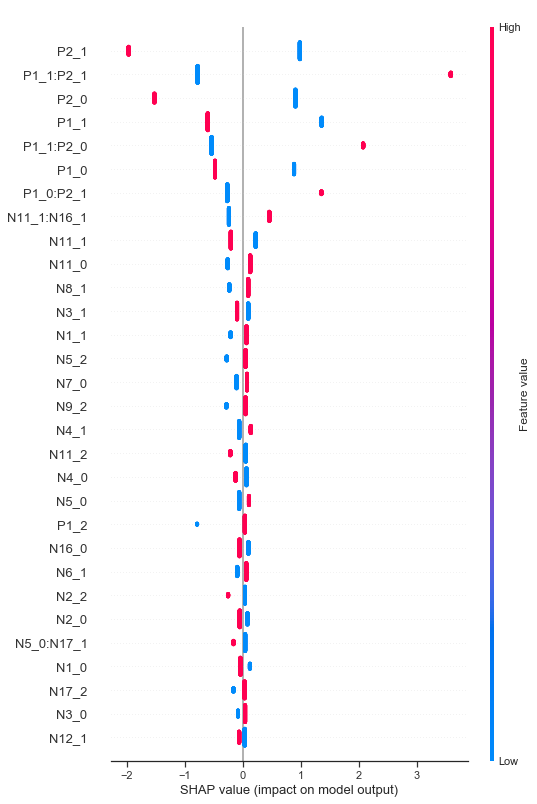

<Figure size 432x288 with 0 Axes>

In [14]:
shap_lr2=run_shap(X_train2, X_test2, lr2, model_type='linear', explainer_options={}, get_shap_values_options={}, overall=False, savefile='../test_data/epistasis.lr2.shap.png')


## XGBoost Example

In [4]:
from xgboost import XGBClassifier
transformer=InteractionTransformer(untrained_model=XGBClassifier(random_state=42),max_train_test_samples=1000,mode_interaction_extract=int(np.sqrt(X_train.shape[1]))) # mode_interaction_extract='sqrt'
transformer.fit(X_train,y_train)

ValueError: feature_names mismatch: ['N0', 'N10', 'N1_0', 'N1_1', 'N1_2', 'N2_0', 'N2_1', 'N2_2', 'N3_0', 'N3_1', 'N3_2', 'N4_0', 'N4_1', 'N4_2', 'N5_0', 'N5_1', 'N5_2', 'N6_0', 'N6_1', 'N6_2', 'N7_0', 'N7_1', 'N7_2', 'N8_0', 'N8_1', 'N8_2', 'N9_0', 'N9_1', 'N9_2', 'N11_0', 'N11_1', 'N11_2', 'N12_0', 'N12_1', 'N12_2', 'N13_0', 'N13_1', 'N13_2', 'N14_0', 'N14_1', 'N14_2', 'N15_0', 'N15_1', 'N15_2', 'N16_0', 'N16_1', 'N16_2', 'N17_0', 'N17_1', 'N17_2', 'P1_0', 'P1_1', 'P1_2', 'P2_0', 'P2_1', 'P2_2'] ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30', 'f31', 'f32', 'f33', 'f34', 'f35', 'f36', 'f37', 'f38', 'f39', 'f40', 'f41', 'f42', 'f43', 'f44', 'f45', 'f46', 'f47', 'f48', 'f49', 'f50', 'f51', 'f52', 'f53', 'f54', 'f55']
expected N7_1, N8_2, N1_1, N16_0, N0, N12_1, P1_2, N13_2, N12_2, N16_2, N14_1, N7_2, N6_0, N1_2, N10, N9_2, N13_1, P2_0, P2_2, N2_2, N8_1, N15_0, N12_0, N15_1, N9_1, N11_0, P1_1, N14_2, N17_0, N14_0, N7_0, N3_2, N17_1, N15_2, N5_0, P2_1, N4_2, N6_1, N11_1, N1_0, N4_0, N4_1, N6_2, N3_1, N8_0, N9_0, N16_1, N2_1, N2_0, N5_2, N3_0, N11_2, N17_2, P1_0, N5_1, N13_0 in input data
training data did not have the following fields: f2, f8, f3, f5, f28, f34, f0, f10, f52, f55, f33, f46, f53, f40, f43, f16, f29, f7, f25, f11, f20, f48, f26, f18, f6, f44, f22, f45, f24, f35, f41, f32, f49, f47, f27, f38, f19, f12, f23, f54, f39, f13, f37, f14, f17, f9, f42, f15, f21, f51, f50, f30, f36, f4, f31, f1